In [17]:
# University of New Mexico
# Authors: Jered Dominguez-Trujillo and Sahba Tashakkori
# Date: May 5, 2020
# Description: Script to Analyze DB Data

# Import Statements
import pandas as pd
import numpy as np
import os
import urllib.request, json
import sys
from matplotlib import pyplot as plt
from datetime import date

In [18]:
def StateDailyCases(pathToCSV):
    df = pd.read_csv(pathToCSV)
    States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]
        Statedf = Statedf.sort_values(by=['DATERECORDED'])

        Positive = [Statedf['POSITIVE'].iloc[ii] - Statedf['POSITIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['POSITIVE']))]
        Negative = [Statedf['NEGATIVE'].iloc[ii] - Statedf['NEGATIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['NEGATIVE']))]
        Total = [Statedf['TOTAL'].iloc[ii] - Statedf['TOTAL'].iloc[ii - 1] for ii in range(1, len(Statedf['TOTAL']))]
        Death = [Statedf['DEATH'].iloc[ii] - Statedf['DEATH'].iloc[ii - 1] for ii in range(1, len(Statedf['DEATH']))]

        axs[0, 0].plot(list(range(1, len(Statedf))), Positive, '-o', label=State)
        axs[0, 1].plot(list(range(1, len(Statedf))), Negative, '-o', label=State)
        axs[1, 0].plot(list(range(1, len(Statedf))), Total, '-o', label=State)
        axs[1, 1].plot(list(range(1, len(Statedf))), Death, '-o', label=State)

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()

    axs[0, 0].set_title('Daily Positive Tests')
    axs[0, 1].set_title('Daily Negative Tests')
    axs[1, 0].set_title('Daily Total Tests')
    axs[1, 1].set_title('Daily Deaths')

In [19]:
def StateTotalCases(pathToCSV):
    df = pd.read_csv(pathToCSV)
    States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]
        Statedf = Statedf.sort_values(by=['DATERECORDED'])

        axs[0, 0].plot(list(range(0, len(Statedf))), Statedf['POSITIVE'], '-o', label=State)
        axs[0, 1].plot(list(range(0, len(Statedf))), Statedf['NEGATIVE'], '-o', label=State)
        axs[1, 0].plot(list(range(0, len(Statedf))), Statedf['TOTAL'], '-o', label=State)
        axs[1, 1].plot(list(range(0, len(Statedf))), Statedf['DEATH'], '-o', label=State)

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()

    axs[0, 0].set_title('Total Positive Tests')
    axs[0, 1].set_title('Total Negative Tests')
    axs[1, 0].set_title('Total Total Tests')
    axs[1, 1].set_title('Total Deaths')

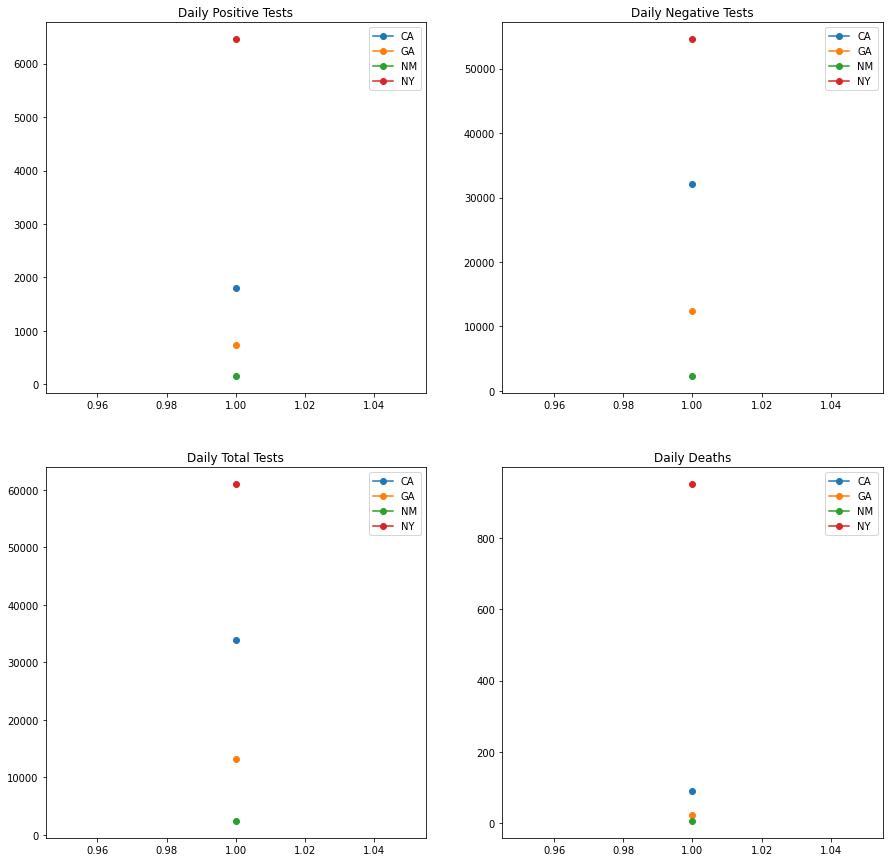

In [20]:
StateDailyCases('./AnalysisData/TestByState.csv')

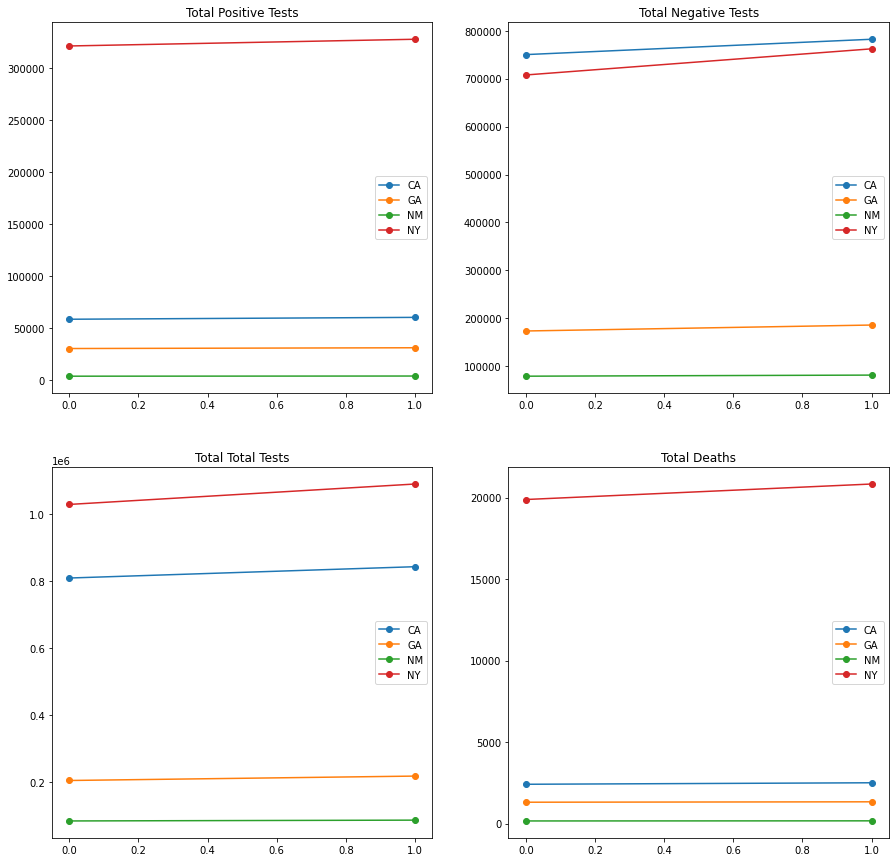

In [21]:
StateTotalCases('./AnalysisData/TestByState.csv')